In [ ]:
# ====================== Imports ======================
import os
import re
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pandas as pd
from tqdm import tqdm

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 8
EPOCHS = 10
MAX_SEQ_LEN = 128
EMBEDDING_DIM = 100
HIDDEN_DIM = 128

# ====================== Custom Tokenizer ======================
class SimpleTokenizer:
    def __init__(self, texts, min_freq=1):
        self.word2idx = {"<PAD>":0, "<UNK>":1}
        self.idx2word = {0:"<PAD>", 1:"<UNK>"}
        self.min_freq = min_freq
        self.build_vocab(texts)

    def build_vocab(self, texts):
        word_freq = {}
        for text in texts:
            words = self.tokenize(text)
            for w in words:
                word_freq[w] = word_freq.get(w, 0) + 1

        idx = 2
        for word, freq in word_freq.items():
            if freq >= self.min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx +=1

    def tokenize(self, text):
        # simple word tokenizer: lowercase + split on non-alpha
        text = text.lower()
        words = re.findall(r'\b\w+\b', text)
        return words

    def encode(self, text, max_len=MAX_SEQ_LEN):
        tokens = self.tokenize(text)
        token_ids = []
        for t in tokens:
            token_ids.append(self.word2idx.get(t, self.word2idx["<UNK>"]))
        # pad or truncate
        if len(token_ids) < max_len:
            token_ids = token_ids + [self.word2idx["<PAD>"]] * (max_len - len(token_ids))
        else:
            token_ids = token_ids[:max_len]
        return torch.tensor(token_ids, dtype=torch.long)

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, dataframe, tokenizer, image_folder, transform=None):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_path = os.path.join(self.image_folder, row["image_name"])
        text = str(row["Captions"])
        label = LABEL_MAP[str(row["Label_Sentiment"]).strip().lower()]

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        input_ids = self.tokenizer.encode(text)

        return image, input_ids, label

# ====================== Custom CNN Backbone ======================
class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),  # 640x640 -> 640x640
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 640x640 -> 320x320

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 320x320 -> 160x160

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 160x160 -> 80x80

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 80x80 -> 40x40

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1), 
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))  # output: (batch, 512, 1, 1)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten (batch, 512)
        return x

# ====================== LSTM Text Encoder ======================
class LSTMTextEncoder(nn.Module):
    def __init__(self, vocab_size, embedding_dim=EMBEDDING_DIM, hidden_dim=HIDDEN_DIM, num_layers=1):
        super(LSTMTextEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input_ids):
        embedded = self.embedding(input_ids)  # (batch, seq_len, embedding_dim)
        packed_output, (hidden, cell) = self.lstm(embedded)  
        # hidden shape: (num_layers * num_directions, batch, hidden_dim)

        # Concatenate forward and backward hidden states from last layer
        hidden_cat = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # (batch, hidden_dim*2)
        hidden_cat = self.dropout(hidden_cat)
        return hidden_cat

# ====================== Combined Model ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, vocab_size, num_classes):
        super(VisionTextClassifier, self).__init__()
        self.vision_model = CustomCNN()
        self.text_model = LSTMTextEncoder(vocab_size)

        self.fc1 = nn.Linear(512 + HIDDEN_DIM*2, 256)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(256, num_classes)

    def forward(self, image, input_ids):
        vision_feat = self.vision_model(image)  # (batch, 512)
        text_feat = self.text_model(input_ids)  # (batch, hidden_dim*2)

        combined = torch.cat((vision_feat, text_feat), dim=1)
        x = self.fc1(combined)
        x = torch.relu(x)
        x = self.dropout(x)
        logits = self.classifier(x)
        return logits

# ====================== Transforms ======================
transform = transforms.Compose(
    [
        transforms.Resize((640, 640)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# ====================== Prepare Data ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")

# Build vocab from captions
all_texts = df['Captions'].astype(str).tolist()
tokenizer = SimpleTokenizer(all_texts, min_freq=1)
vocab_size = len(tokenizer.word2idx)

dataset = VisionTextDataset(df, tokenizer=tokenizer, image_folder="Dataset/Memes", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ====================== Train & Evaluate ======================
model = VisionTextClassifier(vocab_size=vocab_size, num_classes=len(LABEL_MAP)).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

train_losses, val_losses, val_accuracies, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    epoch_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training")
    for image, input_ids, label in loop:
        image = image.to(device)
        input_ids = input_ids.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        outputs = model(image, input_ids)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_losses.append(epoch_loss / len(train_loader))

    model.eval()
    val_loss = 0
    preds, labels = [], []
    loop = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation")
    with torch.no_grad():
        for image, input_ids, label in loop:
            image = image.to(device)
            input_ids = input_ids.to(device)
            label = label.to(device)

            outputs = model(image, input_ids)
            loss = criterion(outputs, label)
            val_loss += loss.item()

            pred = outputs.argmax(dim=1).cpu().tolist()
            preds.extend(pred)
            labels.extend(label.cpu().tolist())

    val_losses.append(val_loss / len(val_loader))
    val_acc = accuracy_score(labels, preds)
    val_f1 = f1_score(labels, preds, average="weighted")
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Epoch {epoch+1}: Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")

# ====================== Plotting ======================
os.makedirs("plots", exist_ok=True)

plt.figure(figsize=(10, 7))
conf_mat = confusion_matrix(labels, preds)
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(len(INV_LABEL_MAP))],
            yticklabels=[INV_LABEL_MAP[i] for i in range(len(INV_LABEL_MAP))])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss", linewidth=2)
plt.plot(val_losses, label="Validation Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/loss_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_accuracies, label="Validation Accuracy", marker="o", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/accuracy_plot.png")
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(val_f1s, label="Validation F1 Score", marker="o", color="green", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Validation F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/f1_score_plot.png")
plt.show()


In [ ]:
# ====================== Imports ======================
import os, re, torch, random
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 15
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ====================== Tokenizer ======================
class SimpleTokenizer:
    def __init__(self, texts, min_freq=1):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.build_vocab(texts, min_freq)

    def build_vocab(self, texts, min_freq):
        word_freq = {}
        for text in texts:
            for word in self.tokenize(text):
                word_freq[word] = word_freq.get(word, 0) + 1
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

    def tokenize(self, text):
        return re.findall(r'\b\w+\b', text.lower())

    def encode(self, text, max_len=MAX_SEQ_LEN):
        tokens = self.tokenize(text)
        ids = [self.word2idx.get(t, 1) for t in tokens]
        # pad (left) or truncate
        ids = ids[-max_len:] if len(ids) > max_len else [0]*(max_len - len(ids)) + ids
        return torch.tensor(ids, dtype=torch.long)

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        input_ids = self.tokenizer.encode(str(row["Captions"]))
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, input_ids, label

# ====================== CNN Encoder ======================
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        return self.encoder(x).flatten(1)

# ====================== LSTM Encoder ======================
class LSTMTextEncoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=EMBEDDING_DIM, hid_dim=HIDDEN_DIM):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        emb = self.dropout(self.embedding(input_ids))
        _, (hidden, _) = self.lstm(emb)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # BiLSTM last hidden state
        return hidden

# ====================== Final Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vision_model = CustomCNN()
        self.text_model = LSTMTextEncoder(vocab_size)
        self.fc = nn.Sequential(
            nn.Linear(256 + HIDDEN_DIM*2, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, image, input_ids):
        vis_feat = self.vision_model(image)
        txt_feat = self.text_model(input_ids)
        x = torch.cat([vis_feat, txt_feat], dim=1)
        return self.fc(x)

# ====================== Transforms ======================
train_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# ====================== Load Data ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
texts = df["Captions"].astype(str).tolist()
tokenizer = SimpleTokenizer(texts)
vocab_size = len(tokenizer.word2idx)

dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes", transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_transform

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# ====================== Train ======================
model = VisionTextClassifier(vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses, val_losses, val_accs, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training")
    for img, ids, lbl in loop:
        img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(img, ids)
        loss = criterion(out, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets, val_loss = [], [], 0
    with torch.no_grad():
        for img, ids, lbl in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
            out = model(img, ids)
            val_loss += criterion(out, lbl).item()
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    scheduler.step()
    val_losses.append(val_loss / len(val_loader))
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    val_accs.append(acc)
    val_f1s.append(f1)
    print(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Acc={acc:.4f}, F1={f1:.4f}")

# ====================== Plot ======================
os.makedirs("plots", exist_ok=True)

plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


In [ ]:
# ====================== Imports ======================
import os, re, torch, random
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 15
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()


# ====================== Load GloVe ======================
def load_glove_embeddings(glove_path, word2idx, embed_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(v) for v in values[1:]], dtype=torch.float)
            embeddings_index[word] = vector

    embedding_matrix = torch.randn(len(word2idx), embed_dim) * 0.05  # random init
    embedding_matrix[0] = torch.zeros(embed_dim)  # PAD idx

    for word, idx in word2idx.items():
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
    return embedding_matrix

# Path to GloVe embeddings
glove_path = "glove/glove.6B.100d.txt"

# ====================== Tokenizer ======================
class SimpleTokenizer:
    def __init__(self, texts, min_freq=1):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.build_vocab(texts, min_freq)

    def build_vocab(self, texts, min_freq):
        word_freq = {}
        for text in texts:
            for word in self.tokenize(text):
                word_freq[word] = word_freq.get(word, 0) + 1
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

    def tokenize(self, text):
        return re.findall(r'\b\w+\b', text.lower())

    def encode(self, text, max_len=MAX_SEQ_LEN):
        tokens = self.tokenize(text)
        ids = [self.word2idx.get(t, 1) for t in tokens]
        # pad (left) or truncate
        ids = ids[-max_len:] if len(ids) > max_len else [0]*(max_len - len(ids)) + ids
        return torch.tensor(ids, dtype=torch.long)

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        input_ids = self.tokenizer.encode(str(row["Captions"]))
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, input_ids, label

# ====================== CNN Encoder ======================
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        return self.encoder(x).flatten(1)

# ====================== LSTM Encoder ======================
class LSTMTextEncoder(nn.Module):
    def __init__(self, embedding_matrix, hid_dim=HIDDEN_DIM):
        super().__init__()
        num_embeddings, emb_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        emb = self.dropout(self.embedding(input_ids))
        _, (hidden, _) = self.lstm(emb)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # BiLSTM last hidden state
        return hidden


# ====================== Final Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.vision_model = CustomCNN()
        self.text_model = LSTMTextEncoder(embedding_matrix)
        self.fc = nn.Sequential(
            nn.Linear(256 + HIDDEN_DIM*2, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, image, input_ids):
        vis_feat = self.vision_model(image)
        txt_feat = self.text_model(input_ids)
        x = torch.cat([vis_feat, txt_feat], dim=1)
        return self.fc(x)

# ====================== Transforms ======================
train_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# ====================== Load Data ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
texts = df["Captions"].astype(str).tolist()
tokenizer = SimpleTokenizer(texts)
vocab_size = len(tokenizer.word2idx)

dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes", transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_transform

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# ====================== Train ======================
embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word2idx, EMBEDDING_DIM)
model = VisionTextClassifier(embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses, val_losses, val_accs, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training")
    for img, ids, lbl in loop:
        img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(img, ids)
        loss = criterion(out, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets, val_loss = [], [], 0
    with torch.no_grad():
        for img, ids, lbl in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
            out = model(img, ids)
            val_loss += criterion(out, lbl).item()
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    scheduler.step()
    val_losses.append(val_loss / len(val_loader))
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    val_accs.append(acc)
    val_f1s.append(f1)
    print(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Acc={acc:.4f}, F1={f1:.4f}")

# ====================== Plot ======================
os.makedirs("plots", exist_ok=True)

plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


In [ ]:
# ====================== Imports ======================
import os, re, torch, random
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 25
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()


# ====================== Load GloVe ======================
def load_glove_embeddings(glove_path, word2idx, embed_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(v) for v in values[1:]], dtype=torch.float)
            embeddings_index[word] = vector

    embedding_matrix = torch.randn(len(word2idx), embed_dim) * 0.05  # random init
    embedding_matrix[0] = torch.zeros(embed_dim)  # PAD idx

    for word, idx in word2idx.items():
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
    return embedding_matrix

# Path to GloVe embeddings
glove_path = "glove/glove.6B.100d.txt"

# ====================== Tokenizer ======================
class SimpleTokenizer:
    def __init__(self, texts, min_freq=1):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.build_vocab(texts, min_freq)

    def build_vocab(self, texts, min_freq):
        word_freq = {}
        for text in texts:
            for word in self.tokenize(text):
                word_freq[word] = word_freq.get(word, 0) + 1
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

    def tokenize(self, text):
        return re.findall(r'\b\w+\b', text.lower())

    def encode(self, text, max_len=MAX_SEQ_LEN):
        tokens = self.tokenize(text)
        ids = [self.word2idx.get(t, 1) for t in tokens]
        # pad (left) or truncate
        ids = ids[-max_len:] if len(ids) > max_len else [0]*(max_len - len(ids)) + ids
        return torch.tensor(ids, dtype=torch.long)

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        input_ids = self.tokenizer.encode(str(row["Captions"]))
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, input_ids, label

# ====================== CNN Encoder ======================
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(), nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        return self.encoder(x).flatten(1)

# ====================== LSTM Encoder ======================
class LSTMTextEncoder(nn.Module):
    def __init__(self, embedding_matrix, hid_dim=HIDDEN_DIM):
        super().__init__()
        num_embeddings, emb_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, hid_dim, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        emb = self.dropout(self.embedding(input_ids))
        _, (hidden, _) = self.lstm(emb)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # BiLSTM last hidden state
        return hidden


# ====================== Final Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.vision_model = CustomCNN()
        self.text_model = LSTMTextEncoder(embedding_matrix)
        self.fc = nn.Sequential(
            nn.Linear(256 + HIDDEN_DIM*2, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, image, input_ids):
        vis_feat = self.vision_model(image)
        txt_feat = self.text_model(input_ids)
        x = torch.cat([vis_feat, txt_feat], dim=1)
        return self.fc(x)

# ====================== Transforms ======================
train_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# ====================== Load Data ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
texts = df["Captions"].astype(str).tolist()
tokenizer = SimpleTokenizer(texts)
vocab_size = len(tokenizer.word2idx)

dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes", transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_transform

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# ====================== Train ======================
embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word2idx, EMBEDDING_DIM)
model = VisionTextClassifier(embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses, val_losses, val_accs, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training")
    for img, ids, lbl in loop:
        img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(img, ids)
        loss = criterion(out, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets, val_loss = [], [], 0
    with torch.no_grad():
        for img, ids, lbl in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
            out = model(img, ids)
            val_loss += criterion(out, lbl).item()
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    scheduler.step()
    val_losses.append(val_loss / len(val_loader))
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    val_accs.append(acc)
    val_f1s.append(f1)
    print(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Acc={acc:.4f}, F1={f1:.4f}")

# ====================== Plot ======================
os.makedirs("plots", exist_ok=True)

plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


In [ ]:
# ====================== Imports ======================
import os, re, torch, random
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 25
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ====================== Load GloVe ======================
def load_glove_embeddings(glove_path, word2idx, embed_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(v) for v in values[1:]], dtype=torch.float)
            embeddings_index[word] = vector

    embedding_matrix = torch.randn(len(word2idx), embed_dim) * 0.05
    embedding_matrix[0] = torch.zeros(embed_dim)

    for word, idx in word2idx.items():
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
    return embedding_matrix

glove_path = "glove/glove.6B.100d.txt"

# ====================== Tokenizer ======================
class SimpleTokenizer:
    def __init__(self, texts, min_freq=1):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.build_vocab(texts, min_freq)

    def build_vocab(self, texts, min_freq):
        word_freq = {}
        for text in texts:
            for word in self.tokenize(text):
                word_freq[word] = word_freq.get(word, 0) + 1
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

    def tokenize(self, text):
        return re.findall(r'\b\w+\b', text.lower())

    def encode(self, text, max_len=MAX_SEQ_LEN):
        tokens = self.tokenize(text)
        ids = [self.word2idx.get(t, 1) for t in tokens]
        ids = ids[-max_len:] if len(ids) > max_len else [0]*(max_len - len(ids)) + ids
        return torch.tensor(ids, dtype=torch.long)

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        input_ids = self.tokenizer.encode(str(row["Captions"]))
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, input_ids, label

# ====================== CNN Encoder ======================
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.LeakyReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        return self.encoder(x).flatten(1)

# ====================== LSTM Encoder ======================
class LSTMTextEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        num_embeddings, emb_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, HIDDEN_DIM, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        emb = self.dropout(self.embedding(input_ids))
        output, (hn, cn) = self.lstm(emb)
        feat = torch.cat((hn[-2], hn[-1]), dim=1)  # BiLSTM
        return feat

# ====================== Final Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.vision_model = CustomCNN()
        self.text_model = LSTMTextEncoder(embedding_matrix)
        self.fc = nn.Sequential(
            nn.Linear(256 + HIDDEN_DIM*2, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, image, input_ids):
        vis_feat = self.vision_model(image)
        txt_feat = self.text_model(input_ids)
        x = torch.cat([vis_feat, txt_feat], dim=1)
        return self.fc(x)

# ====================== Transforms ======================
train_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# ====================== Load Data ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
texts = df["Captions"].astype(str).tolist()
tokenizer = SimpleTokenizer(texts)
embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word2idx, EMBEDDING_DIM)

dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes", transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_transform

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# ====================== Train ======================
model = VisionTextClassifier(embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses, val_losses, val_accs, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training")
    for img, ids, lbl in loop:
        img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(img, ids)
        loss = criterion(out, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets, val_loss = [], [], 0
    with torch.no_grad():
        for img, ids, lbl in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
            out = model(img, ids)
            val_loss += criterion(out, lbl).item()
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    scheduler.step()
    val_losses.append(val_loss / len(val_loader))
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    val_accs.append(acc)
    val_f1s.append(f1)
    print(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Acc={acc:.4f}, F1={f1:.4f}")

# ====================== Plot ======================
os.makedirs("plots", exist_ok=True)

plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


In [ ]:
# ====================== Imports ======================
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

# ====================== Configuration ======================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MAX_LEN = 100  # Maximum sequence length for text
VOCAB_SIZE = 10000  # Vocabulary size for text
EMBED_DIM = 128
HIDDEN_DIM = 128
NUM_CLASSES = 3  # negative, positive, neutral
BATCH_SIZE = 32
EPOCHS = 10
IMAGE_SIZE = (224, 224)

# ====================== Basic Tokenizer ======================
def simple_tokenizer(text, vocab, max_len=MAX_LEN):
    tokens = text.lower().split()
    token_ids = [vocab.get(token, vocab["<unk>"]) for token in tokens]
    if len(token_ids) < max_len:
        token_ids += [vocab["<pad>"]] * (max_len - len(token_ids))
    else:
        token_ids = token_ids[:max_len]
    return token_ids

# ====================== Vocabulary Builder ======================
def build_vocab(texts, vocab_size=VOCAB_SIZE):
    from collections import Counter
    counter = Counter()
    for text in texts:
        tokens = text.lower().split()
        counter.update(tokens)
    most_common = counter.most_common(vocab_size - 2)
    vocab = {"<pad>": 0, "<unk>": 1}
    vocab.update({word: i + 2 for i, (word, _) in enumerate(most_common)})
    return vocab

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, vocab, image_dir, transform=None):
        self.df = df
        self.vocab = vocab
        self.image_dir = image_dir
        self.transform = transform
        self.label_map = {"negative": 0, "positive": 1, "neutral": 2}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = os.path.join(self.image_dir, row["image_name"])
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        text = row["Captions"]
        text_ids = simple_tokenizer(text, self.vocab)

        label = self.label_map[row["Label_Sentiment"]]
        return {
            "image": image,
            "text_ids": torch.tensor(text_ids, dtype=torch.long),
            "label": torch.tensor(label, dtype=torch.long),
        }

# ====================== Models ======================
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
        )
        self.fc = nn.Linear(128, 128)

    def forward(self, x):
        x = self.cnn(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

class CustomLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 128)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])

class MultimodalClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super().__init__()
        self.vision_model = CustomCNN()
        self.text_model = CustomLSTM(vocab_size, embed_dim, hidden_dim)
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes),
        )

    def forward(self, image, text_ids):
        vision_feat = self.vision_model(image)
        text_feat = self.text_model(text_ids)
        combined = torch.cat((vision_feat, text_feat), dim=1)
        return self.classifier(combined)

# ====================== Load Dataset ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
vocab = build_vocab(df["Captions"].tolist())

transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["Label_Sentiment"])
train_dataset = VisionTextDataset(train_df, vocab, "Dataset/Memes", transform)
val_dataset = VisionTextDataset(val_df, vocab, "Dataset/Memes", transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

# ====================== Train ======================
model = MultimodalClassifier(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(EPOCHS):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = batch["image"].to(device)
        texts = batch["text_ids"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(images, texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    print(f"Epoch {epoch+1} Loss: {running_loss/len(train_loader):.4f} Accuracy: {correct/total:.4f}")

# ====================== Evaluation ======================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for batch in val_loader:
        images = batch["image"].to(device)
        texts = batch["text_ids"].to(device)
        labels = batch["label"].to(device)
        outputs = model(images, texts)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ====================== Report ======================
labels_map = ["negative", "positive", "neutral"]
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=labels_map))

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels_map, yticklabels=labels_map)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
# ====================== Imports ======================
import os, re, torch, random
import torch.nn as nn
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
from sklearn.utils.class_weight import compute_class_weight

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 25
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ====================== Load GloVe ======================
def load_glove_embeddings(glove_path, word2idx, embed_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = torch.tensor([float(v) for v in values[1:]], dtype=torch.float)
            embeddings_index[word] = vector

    embedding_matrix = torch.randn(len(word2idx), embed_dim) * 0.05
    embedding_matrix[0] = torch.zeros(embed_dim)

    for word, idx in word2idx.items():
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
    return embedding_matrix

glove_path = "glove/glove.6B.100d.txt"

# ====================== Tokenizer ======================
class SimpleTokenizer:
    def __init__(self, texts, min_freq=1):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.idx2word = {0: "<PAD>", 1: "<UNK>"}
        self.build_vocab(texts, min_freq)

    def build_vocab(self, texts, min_freq):
        word_freq = {}
        for text in texts:
            for word in self.tokenize(text):
                word_freq[word] = word_freq.get(word, 0) + 1
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                self.idx2word[idx] = word
                idx += 1

    def tokenize(self, text):
        return re.findall(r'\b\w+\b', text.lower())

    def encode(self, text, max_len=MAX_SEQ_LEN):
        tokens = self.tokenize(text)
        ids = [self.word2idx.get(t, 1) for t in tokens]
        ids = ids[-max_len:] if len(ids) > max_len else [0]*(max_len - len(ids)) + ids
        return torch.tensor(ids, dtype=torch.long)

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        input_ids = self.tokenizer.encode(str(row["Captions"]))
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, input_ids, label

# ====================== CNN Encoder ======================
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.fc = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(channel, channel // reduction),
            nn.ReLU(),
            nn.Linear(channel // reduction, channel),
            nn.Sigmoid()
        )
    def forward(self, x):
        w = self.fc(x).unsqueeze(-1).unsqueeze(-1)
        return x * w

class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            SEBlock(128),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        return self.encoder(x).flatten(1)


# ====================== LSTM Encoder ======================
class GRUTextEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        num_embeddings, emb_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=0)
        self.gru = nn.GRU(emb_dim, HIDDEN_DIM, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)
        self.norm = nn.LayerNorm(HIDDEN_DIM * 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        emb = self.dropout(self.embedding(input_ids))
        _, hn = self.gru(emb)
        feat = torch.cat((hn[-2], hn[-1]), dim=1)
        return self.norm(feat)


# ====================== Final Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.vision_model = CustomCNN()
        self.text_model = GRUTextEncoder(embedding_matrix)
        self.fc = nn.Sequential(
            nn.Linear(256 + HIDDEN_DIM*2, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, NUM_CLASSES)
        )
    def forward(self, image, input_ids):
        vis_feat = self.vision_model(image)
        txt_feat = self.text_model(input_ids)
        x = torch.cat([vis_feat, txt_feat], dim=1)
        return self.fc(x)

# ====================== Transforms ======================
train_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
    transforms.RandomAffine(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])


val_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# ====================== Load Data ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
texts = df["Captions"].astype(str).tolist()
tokenizer = SimpleTokenizer(texts)
embedding_matrix = load_glove_embeddings(glove_path, tokenizer.word2idx, EMBEDDING_DIM)

dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes", transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_transform

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# ====================== Train ======================
model = VisionTextClassifier(embedding_matrix).to(device)
cls_weights = compute_class_weight('balanced', classes=np.unique(df["Label_Sentiment"].str.lower()), y=df["Label_Sentiment"].str.lower())
weights_tensor = torch.tensor([cls_weights[LABEL_MAP[k]] for k in LABEL_MAP], dtype=torch.float).to(device)
criterion = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses, val_losses, val_accs, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training")
    for img, ids, lbl in loop:
        img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(img, ids)
        loss = criterion(out, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets, val_loss = [], [], 0
    with torch.no_grad():
        for img, ids, lbl in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
            out = model(img, ids)
            val_loss += criterion(out, lbl).item()
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    scheduler.step()
    val_losses.append(val_loss / len(val_loader))
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    val_accs.append(acc)
    val_f1s.append(f1)
    print(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Acc={acc:.4f}, F1={f1:.4f}")

# ====================== Plot ======================
os.makedirs("plots", exist_ok=True)

plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


In [ ]:
# ====================== Imports ======================
import os, re, torch, random, numpy as np
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 25
MAX_SEQ_LEN = 100
EMBEDDING_DIM = 100
HIDDEN_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ====================== Load GloVe ======================
def load_glove_embeddings(glove_path, word2idx, embed_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            if word in word2idx:
                vector = torch.tensor([float(v) for v in values[1:]], dtype=torch.float)
                embeddings_index[word] = vector
    embedding_matrix = torch.randn(len(word2idx), embed_dim) * 0.05
    embedding_matrix[0] = torch.zeros(embed_dim)
    for word, idx in word2idx.items():
        vec = embeddings_index.get(word)
        if vec is not None:
            embedding_matrix[idx] = vec
    return embedding_matrix

# ====================== Tokenizer ======================
class SimpleTokenizer:
    def __init__(self, texts, min_freq=1):
        self.word2idx = {"<PAD>": 0, "<UNK>": 1}
        self.build_vocab(texts, min_freq)

    def build_vocab(self, texts, min_freq):
        word_freq = {}
        for text in texts:
            for word in self.tokenize(text):
                word_freq[word] = word_freq.get(word, 0) + 1
        idx = 2
        for word, freq in word_freq.items():
            if freq >= min_freq:
                self.word2idx[word] = idx
                idx += 1

    def tokenize(self, text):
        return re.findall(r'\b\w+\b', text.lower())

    def encode(self, text, max_len=MAX_SEQ_LEN):
        tokens = self.tokenize(text)
        ids = [self.word2idx.get(t, 1) for t in tokens]
        ids = ids[-max_len:] if len(ids) > max_len else [0]*(max_len - len(ids)) + ids
        return torch.tensor(ids, dtype=torch.long)

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        input_ids = self.tokenizer.encode(str(row["Captions"]))
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, input_ids, label

# ====================== CNN Encoder ======================
class CustomCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.BatchNorm2d(32), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Dropout(0.3)
        )
    def forward(self, x):
        return self.encoder(x).flatten(1)

# ====================== LSTM Encoder ======================
class LSTMTextEncoder(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        num_embeddings, emb_dim = embedding_matrix.shape
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze=True, padding_idx=0)
        self.lstm = nn.LSTM(emb_dim, HIDDEN_DIM, batch_first=True, bidirectional=True, num_layers=2, dropout=0.3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids):
        emb = self.dropout(self.embedding(input_ids))
        output, (hn, cn) = self.lstm(emb)
        feat = torch.cat((hn[-2], hn[-1]), dim=1)
        return feat

# ====================== Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, embedding_matrix):
        super().__init__()
        self.vision_model = CustomCNN()
        self.text_model = LSTMTextEncoder(embedding_matrix)
        self.fc = nn.Sequential(
            nn.Linear(256 + HIDDEN_DIM*2, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, NUM_CLASSES)
        )

    def forward(self, image, input_ids):
        vis_feat = self.vision_model(image)
        txt_feat = self.text_model(input_ids)
        x = torch.cat([vis_feat, txt_feat], dim=1)
        return self.fc(x)

# ====================== Transforms ======================
train_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

val_transform = transforms.Compose([
    transforms.Resize((640, 640)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3),
])

# ====================== Load Dataset ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
texts = df["Captions"].astype(str).tolist()
tokenizer = SimpleTokenizer(texts)
embedding_matrix = load_glove_embeddings("glove/glove.6B.100d.txt", tokenizer.word2idx, EMBEDDING_DIM)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(df["Label_Sentiment"].map(LABEL_MAP)), y=df["Label_Sentiment"].map(LABEL_MAP))
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes", transform=train_transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])
train_set.dataset.transform = train_transform
val_set.dataset.transform = val_transform

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# ====================== Training ======================
model = VisionTextClassifier(embedding_matrix).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses, val_losses, val_accs, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training")
    for img, ids, lbl in loop:
        img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(img, ids)
        loss = criterion(out, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets, val_loss = [], [], 0
    with torch.no_grad():
        for img, ids, lbl in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            img, ids, lbl = img.to(device), ids.to(device), lbl.to(device)
            out = model(img, ids)
            val_loss += criterion(out, lbl).item()
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(lbl.cpu().numpy())

    scheduler.step()
    val_losses.append(val_loss / len(val_loader))
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    val_accs.append(acc)
    val_f1s.append(f1)
    print(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Acc={acc:.4f}, F1={f1:.4f}")
    print(classification_report(targets, preds, target_names=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)]))

# ====================== Plots ======================
os.makedirs("plots", exist_ok=True)

plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True")
plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


In [ ]:
# ====================== Imports ======================
import os, re, torch, random, numpy as np
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 25
MAX_SEQ_LEN = 128
HIDDEN_DIM = 128
IMAGE_DIM = 128
TEXT_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        encoded = self.tokenizer(row["Captions"], padding="max_length", truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt")
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, encoded["input_ids"].squeeze(0), encoded["attention_mask"].squeeze(0), label

# ====================== CNN Encoder ======================
class CNNImageEncoder(nn.Module):
    def __init__(self, output_dim):
        super(CNNImageEncoder, self).__init__()
        from torchvision import models
        base_model = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Linear(512 * 2, output_dim)

    def forward(self, x):
        x = self.features(x)
        avg_feat = self.avgpool(x).view(x.size(0), -1)
        max_feat = self.maxpool(x).view(x.size(0), -1)
        feat = torch.cat([avg_feat, max_feat], dim=1)
        return self.fc(feat)

# ====================== Text Encoder ======================
class TextEncoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)
        return self.fc(x)

# ====================== Multimodal Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, image_dim, text_dim, hidden_dim, num_classes):
        super(VisionTextClassifier, self).__init__()
        self.image_encoder = CNNImageEncoder(image_dim)
        self.text_encoder = TextEncoder(hidden_dim, text_dim)
        self.classifier = nn.Sequential(
            nn.Linear(image_dim + text_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.image_encoder(image)
        txt_feat = self.text_encoder(input_ids, attention_mask)
        x = torch.cat((img_feat, txt_feat), dim=1)
        return self.classifier(x)

# ====================== Tokenizer and Dataset ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# ====================== Training ======================
model = VisionTextClassifier(IMAGE_DIM, TEXT_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)
class_weights = compute_class_weight('balanced', classes=np.unique(df["Label_Sentiment"].map(LABEL_MAP)), y=df["Label_Sentiment"].map(LABEL_MAP))
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_losses, val_losses, val_accs, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for img, ids, mask, lbl in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        img, ids, mask, lbl = img.to(device), ids.to(device), mask.to(device), lbl.to(device)
        optimizer.zero_grad()
        output = model(img, ids, mask)
        loss = criterion(output, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets, val_loss = [], [], 0
    with torch.no_grad():
        for img, ids, mask, lbl in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            img, ids, mask, lbl = img.to(device), ids.to(device), mask.to(device), lbl.to(device)
            output = model(img, ids, mask)
            val_loss += criterion(output, lbl).item()
            preds.extend(output.argmax(1).cpu().numpy())
            targets.extend(lbl.cpu().numpy())
    scheduler.step()
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(acc)
    val_f1s.append(f1)
    print(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Acc={acc:.4f}, F1={f1:.4f}")
    print(classification_report(targets, preds, target_names=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)]))

# ====================== Plots ======================
os.makedirs("plots", exist_ok=True)
plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


In [ ]:
# ====================== Imports ======================
import os, re, torch, random, numpy as np
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 25
MAX_SEQ_LEN = 128
HIDDEN_DIM = 128
IMAGE_DIM = 128
TEXT_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        encoded = self.tokenizer(row["Captions"], padding="max_length", truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt")
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, encoded["input_ids"].squeeze(0), encoded["attention_mask"].squeeze(0), label

# ====================== CNN Encoder ======================
class CNNImageEncoder(nn.Module):
    def __init__(self, output_dim):
        super(CNNImageEncoder, self).__init__()
        from torchvision import models
        base_model = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512 * 2, output_dim)

    def forward(self, x):
        x = self.features(x)
        avg_feat = self.avgpool(x).view(x.size(0), -1)
        max_feat = self.maxpool(x).view(x.size(0), -1)
        feat = torch.cat([avg_feat, max_feat], dim=1)
        feat = self.dropout(feat)
        return self.fc(feat)

# ====================== Text Encoder ======================
class TextEncoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)
        x = self.dropout(x)
        return self.fc(x)

# ====================== Multimodal Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, image_dim, text_dim, hidden_dim, num_classes):
        super(VisionTextClassifier, self).__init__()
        self.image_encoder = CNNImageEncoder(image_dim)
        self.text_encoder = TextEncoder(hidden_dim, text_dim)
        self.classifier = nn.Sequential(
            nn.Linear(image_dim + text_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.image_encoder(image)
        txt_feat = self.text_encoder(input_ids, attention_mask)
        x = torch.cat((img_feat, txt_feat), dim=1)
        return self.classifier(x)

# ====================== Tokenizer and Dataset ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# ====================== Model, Loss, Optimizer ======================
model = VisionTextClassifier(IMAGE_DIM, TEXT_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(df["Label_Sentiment"].map(LABEL_MAP)), y=df["Label_Sentiment"].map(LABEL_MAP))
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

# Optional: Use focal loss
# class FocalLoss(nn.Module):
#     def __init__(self, alpha=1, gamma=2, weight=None):
#         super(FocalLoss, self).__init__()
#         self.alpha = alpha
#         self.gamma = gamma
#         self.weight = weight
#     def forward(self, input, target):
#         ce_loss = nn.CrossEntropyLoss(weight=self.weight, reduction='none')(input, target)
#         pt = torch.exp(-ce_loss)
#         return (self.alpha * (1-pt)**self.gamma * ce_loss).mean()
# criterion = FocalLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ====================== Training ======================
train_losses, val_losses, val_accs, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for img, ids, mask, lbl in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        img, ids, mask, lbl = img.to(device), ids.to(device), mask.to(device), lbl.to(device)
        optimizer.zero_grad()
        output = model(img, ids, mask)
        loss = criterion(output, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets, val_loss = [], [], 0
    with torch.no_grad():
        for img, ids, mask, lbl in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            img, ids, mask, lbl = img.to(device), ids.to(device), mask.to(device), lbl.to(device)
            output = model(img, ids, mask)
            val_loss += criterion(output, lbl).item()
            preds.extend(output.argmax(1).cpu().numpy())
            targets.extend(lbl.cpu().numpy())
    scheduler.step()
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(acc)
    val_f1s.append(f1)
    print(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Acc={acc:.4f}, F1={f1:.4f}")
    print(classification_report(targets, preds, target_names=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)]))

# ====================== Plots ======================
os.makedirs("plots", exist_ok=True)
plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


In [ ]:
# ====================== Imports ======================
import os, re, torch, random, numpy as np
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, random_split, Dataset
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 25
MAX_SEQ_LEN = 128
HIDDEN_DIM = 128
IMAGE_DIM = 128
TEXT_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        encoded = self.tokenizer(row["Captions"], padding="max_length", truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt")
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, encoded["input_ids"].squeeze(0), encoded["attention_mask"].squeeze(0), label

# ====================== CNN Encoder ======================
class CNNImageEncoder(nn.Module):
    def __init__(self, output_dim):
        super(CNNImageEncoder, self).__init__()
        from torchvision import models
        base_model = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(512 * 2, output_dim)

    def forward(self, x):
        x = self.features(x)
        avg_feat = self.avgpool(x).view(x.size(0), -1)
        max_feat = self.maxpool(x).view(x.size(0), -1)
        feat = torch.cat([avg_feat, max_feat], dim=1)
        feat = self.dropout(feat)
        return self.fc(feat)

# ====================== Text Encoder ======================
class TextEncoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(TextEncoder, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)
        x = self.dropout(x)
        return self.fc(x)

# ====================== Multimodal Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, image_dim, text_dim, hidden_dim, num_classes):
        super(VisionTextClassifier, self).__init__()
        self.image_encoder = CNNImageEncoder(image_dim)
        self.text_encoder = TextEncoder(hidden_dim, text_dim)
        self.classifier = nn.Sequential(
            nn.Linear(image_dim + text_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.image_encoder(image)
        txt_feat = self.text_encoder(input_ids, attention_mask)
        x = torch.cat((img_feat, txt_feat), dim=1)
        return self.classifier(x)

# ====================== Tokenizer and Dataset ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes")

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_set, val_set = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE)

# ====================== Model, Loss, Optimizer ======================
model = VisionTextClassifier(IMAGE_DIM, TEXT_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(df["Label_Sentiment"].map(LABEL_MAP)), y=df["Label_Sentiment"].map(LABEL_MAP))
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

# Optional: Use focal loss
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
    def forward(self, input, target):
        ce_loss = nn.CrossEntropyLoss(weight=self.weight, reduction='none')(input, target)
        pt = torch.exp(-ce_loss)
        return (self.alpha * (1-pt)**self.gamma * ce_loss).mean()
criterion = FocalLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ====================== Training ======================
train_losses, val_losses, val_accs, val_f1s = [], [], [], []

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for img, ids, mask, lbl in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Training"):
        img, ids, mask, lbl = img.to(device), ids.to(device), mask.to(device), lbl.to(device)
        optimizer.zero_grad()
        output = model(img, ids, mask)
        loss = criterion(output, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets, val_loss = [], [], 0
    with torch.no_grad():
        for img, ids, mask, lbl in tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCHS} - Validation"):
            img, ids, mask, lbl = img.to(device), ids.to(device), mask.to(device), lbl.to(device)
            output = model(img, ids, mask)
            val_loss += criterion(output, lbl).item()
            preds.extend(output.argmax(1).cpu().numpy())
            targets.extend(lbl.cpu().numpy())
    scheduler.step()
    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average="weighted")
    val_losses.append(val_loss / len(val_loader))
    val_accs.append(acc)
    val_f1s.append(f1)
    print(f"Epoch {epoch+1}: Val Loss={val_losses[-1]:.4f}, Acc={acc:.4f}, F1={f1:.4f}")
    print(classification_report(targets, preds, target_names=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)]))

# ====================== Plots ======================
os.makedirs("plots", exist_ok=True)
plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'ElectraTokenizer'. 
The class this function is called from is 'BertTokenizer'.
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
You are using a model of type electra to instantiate a mo


Epoch 1: Train Loss=270.7755  Val Acc=0.1133  F1=0.0805
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2730
    positive       0.48      0.15      0.23      1348
     neutral       0.07      1.00      0.14       291

    accuracy                           0.11      4369
   macro avg       0.19      0.38      0.12      4369
weighted avg       0.15      0.11      0.08      4369



Epoch 2/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/23: 100%|██████████| 274/274 [02:09<00:00,  2.12it/s]
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric


Epoch 2: Train Loss=183.8527  Val Acc=0.3353  F1=0.1838
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2730
    positive       0.35      0.89      0.50      1348
     neutral       0.28      0.92      0.43       291

    accuracy                           0.34      4369
   macro avg       0.21      0.60      0.31      4369
weighted avg       0.13      0.34      0.18      4369



Epoch 3/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/23: 100%|██████████| 274/274 [02:05<00:00,  2.18it/s]



Epoch 3: Train Loss=126.8774  Val Acc=0.3527  F1=0.1949
              precision    recall  f1-score   support

    negative       0.83      0.00      0.00      2730
    positive       0.34      0.94      0.50      1348
     neutral       0.41      0.90      0.57       291

    accuracy                           0.35      4369
   macro avg       0.53      0.62      0.36      4369
weighted avg       0.65      0.35      0.19      4369



Epoch 4/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 4/23: 100%|██████████| 274/274 [02:08<00:00,  2.13it/s]



Epoch 4: Train Loss=102.2520  Val Acc=0.3786  F1=0.2358
              precision    recall  f1-score   support

    negative       0.91      0.03      0.06      2730
    positive       0.36      0.96      0.52      1348
     neutral       0.43      0.97      0.60       291

    accuracy                           0.38      4369
   macro avg       0.57      0.65      0.39      4369
weighted avg       0.71      0.38      0.24      4369



Epoch 5/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 5/23: 100%|██████████| 274/274 [02:05<00:00,  2.18it/s]



Epoch 5: Train Loss=88.6548  Val Acc=0.4143  F1=0.3195
              precision    recall  f1-score   support

    negative       0.90      0.11      0.19      2730
    positive       0.38      0.91      0.53      1348
     neutral       0.37      1.00      0.54       291

    accuracy                           0.41      4369
   macro avg       0.55      0.67      0.42      4369
weighted avg       0.70      0.41      0.32      4369



Epoch 6/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 6/23: 100%|██████████| 274/274 [02:10<00:00,  2.10it/s]



Epoch 6: Train Loss=57.2152  Val Acc=0.4640  F1=0.3955
              precision    recall  f1-score   support

    negative       0.90      0.17      0.29      2730
    positive       0.38      0.94      0.54      1348
     neutral       0.54      1.00      0.70       291

    accuracy                           0.46      4369
   macro avg       0.61      0.70      0.51      4369
weighted avg       0.71      0.46      0.40      4369



Epoch 7/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 7/23: 100%|██████████| 274/274 [02:09<00:00,  2.12it/s]



Epoch 7: Train Loss=49.0700  Val Acc=0.4601  F1=0.3835
              precision    recall  f1-score   support

    negative       0.93      0.16      0.27      2730
    positive       0.38      0.96      0.54      1348
     neutral       0.59      1.00      0.74       291

    accuracy                           0.46      4369
   macro avg       0.63      0.71      0.52      4369
weighted avg       0.74      0.46      0.38      4369



Epoch 8/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 8/23: 100%|██████████| 274/274 [02:09<00:00,  2.12it/s]



Epoch 8: Train Loss=32.0982  Val Acc=0.5006  F1=0.4483
              precision    recall  f1-score   support

    negative       0.94      0.22      0.35      2730
    positive       0.39      0.96      0.56      1348
     neutral       0.71      1.00      0.83       291

    accuracy                           0.50      4369
   macro avg       0.68      0.73      0.58      4369
weighted avg       0.75      0.50      0.45      4369



Epoch 9/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 9/23: 100%|██████████| 274/274 [02:08<00:00,  2.14it/s]



Epoch 9: Train Loss=36.8922  Val Acc=0.4685  F1=0.3968
              precision    recall  f1-score   support

    negative       0.96      0.16      0.27      2730
    positive       0.37      0.99      0.54      1348
     neutral       0.87      0.99      0.92       291

    accuracy                           0.47      4369
   macro avg       0.73      0.71      0.58      4369
weighted avg       0.77      0.47      0.40      4369



Epoch 10/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 10/23: 100%|██████████| 274/274 [02:09<00:00,  2.12it/s]



Epoch 10: Train Loss=25.5973  Val Acc=0.5615  F1=0.5352
              precision    recall  f1-score   support

    negative       0.96      0.31      0.47      2730
    positive       0.42      0.97      0.59      1348
     neutral       0.82      1.00      0.90       291

    accuracy                           0.56      4369
   macro avg       0.73      0.76      0.65      4369
weighted avg       0.78      0.56      0.54      4369



Epoch 11/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 11/23: 100%|██████████| 274/274 [02:07<00:00,  2.15it/s]



Epoch 11: Train Loss=26.4542  Val Acc=0.5491  F1=0.5170
              precision    recall  f1-score   support

    negative       0.95      0.30      0.45      2730
    positive       0.42      0.96      0.58      1348
     neutral       0.69      1.00      0.82       291

    accuracy                           0.55      4369
   macro avg       0.69      0.75      0.62      4369
weighted avg       0.77      0.55      0.52      4369



Epoch 12/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 12/23: 100%|██████████| 274/274 [02:07<00:00,  2.15it/s]



Epoch 12: Train Loss=18.4028  Val Acc=0.5937  F1=0.5761
              precision    recall  f1-score   support

    negative       0.98      0.36      0.53      2730
    positive       0.44      0.98      0.60      1348
     neutral       0.85      1.00      0.92       291

    accuracy                           0.59      4369
   macro avg       0.76      0.78      0.68      4369
weighted avg       0.80      0.59      0.58      4369



Epoch 13/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 13/23: 100%|██████████| 274/274 [02:10<00:00,  2.10it/s]



Epoch 13: Train Loss=49.1201  Val Acc=0.5697  F1=0.5459
              precision    recall  f1-score   support

    negative       0.99      0.32      0.48      2730
    positive       0.42      0.99      0.59      1348
     neutral       0.96      1.00      0.98       291

    accuracy                           0.57      4369
   macro avg       0.79      0.77      0.68      4369
weighted avg       0.81      0.57      0.55      4369



Epoch 14/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 14/23: 100%|██████████| 274/274 [02:06<00:00,  2.17it/s]



Epoch 14: Train Loss=36.0855  Val Acc=0.6402  F1=0.6340
              precision    recall  f1-score   support

    negative       0.99      0.43      0.60      2730
    positive       0.46      0.99      0.63      1348
     neutral       0.95      1.00      0.97       291

    accuracy                           0.64      4369
   macro avg       0.80      0.81      0.73      4369
weighted avg       0.82      0.64      0.63      4369



Epoch 15/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 15/23: 100%|██████████| 274/274 [02:07<00:00,  2.14it/s]



Epoch 15: Train Loss=15.7046  Val Acc=0.7189  F1=0.7216
              precision    recall  f1-score   support

    negative       0.98      0.56      0.71      2730
    positive       0.53      0.98      0.69      1348
     neutral       0.90      1.00      0.95       291

    accuracy                           0.72      4369
   macro avg       0.81      0.85      0.78      4369
weighted avg       0.84      0.72      0.72      4369



Epoch 16/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 16/23: 100%|██████████| 274/274 [02:09<00:00,  2.12it/s]



Epoch 16: Train Loss=22.7906  Val Acc=0.7693  F1=0.7736
              precision    recall  f1-score   support

    negative       0.99      0.64      0.78      2730
    positive       0.58      0.98      0.73      1348
     neutral       0.90      1.00      0.95       291

    accuracy                           0.77      4369
   macro avg       0.82      0.87      0.82      4369
weighted avg       0.86      0.77      0.77      4369



Epoch 17/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 17/23: 100%|██████████| 274/274 [02:10<00:00,  2.10it/s]



Epoch 17: Train Loss=46.0260  Val Acc=0.7388  F1=0.7428
              precision    recall  f1-score   support

    negative       0.99      0.59      0.74      2730
    positive       0.55      0.99      0.70      1348
     neutral       0.95      1.00      0.97       291

    accuracy                           0.74      4369
   macro avg       0.83      0.86      0.80      4369
weighted avg       0.85      0.74      0.74      4369



Epoch 18/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 18/23: 100%|██████████| 274/274 [02:09<00:00,  2.11it/s]



Epoch 18: Train Loss=12.4894  Val Acc=0.8043  F1=0.8086
              precision    recall  f1-score   support

    negative       0.99      0.69      0.82      2730
    positive       0.62      0.99      0.76      1348
     neutral       0.90      1.00      0.94       291

    accuracy                           0.80      4369
   macro avg       0.84      0.89      0.84      4369
weighted avg       0.87      0.80      0.81      4369



Epoch 19/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 19/23: 100%|██████████| 274/274 [02:09<00:00,  2.11it/s]



Epoch 19: Train Loss=42.0412  Val Acc=0.8185  F1=0.8229
              precision    recall  f1-score   support

    negative       0.99      0.72      0.83      2730
    positive       0.64      0.99      0.78      1348
     neutral       0.93      1.00      0.96       291

    accuracy                           0.82      4369
   macro avg       0.85      0.90      0.86      4369
weighted avg       0.88      0.82      0.82      4369



Epoch 20/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 20/23: 100%|██████████| 274/274 [02:08<00:00,  2.13it/s]



Epoch 20: Train Loss=9.9951  Val Acc=0.8121  F1=0.8167
              precision    recall  f1-score   support

    negative       0.99      0.70      0.82      2730
    positive       0.63      0.99      0.77      1348
     neutral       0.94      1.00      0.97       291

    accuracy                           0.81      4369
   macro avg       0.85      0.90      0.85      4369
weighted avg       0.88      0.81      0.82      4369



Epoch 21/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 21/23: 100%|██████████| 274/274 [02:08<00:00,  2.13it/s]



Epoch 21: Train Loss=10.1398  Val Acc=0.8608  F1=0.8636
              precision    recall  f1-score   support

    negative       0.99      0.79      0.88      2730
    positive       0.71      0.98      0.83      1348
     neutral       0.86      1.00      0.92       291

    accuracy                           0.86      4369
   macro avg       0.85      0.92      0.88      4369
weighted avg       0.90      0.86      0.86      4369



Epoch 22/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 22/23: 100%|██████████| 274/274 [02:10<00:00,  2.10it/s]



Epoch 22: Train Loss=12.6003  Val Acc=0.8036  F1=0.8086
              precision    recall  f1-score   support

    negative       1.00      0.69      0.81      2730
    positive       0.61      1.00      0.76      1348
     neutral       0.96      1.00      0.98       291

    accuracy                           0.80      4369
   macro avg       0.86      0.89      0.85      4369
weighted avg       0.88      0.80      0.81      4369



Epoch 23/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 23/23: 100%|██████████| 274/274 [02:08<00:00,  2.14it/s]



Epoch 23: Train Loss=35.3895  Val Acc=0.7942  F1=0.7994
              precision    recall  f1-score   support

    negative       1.00      0.67      0.80      2730
    positive       0.60      1.00      0.75      1348
     neutral       0.98      1.00      0.99       291

    accuracy                           0.79      4369
   macro avg       0.86      0.89      0.85      4369
weighted avg       0.87      0.79      0.80      4369



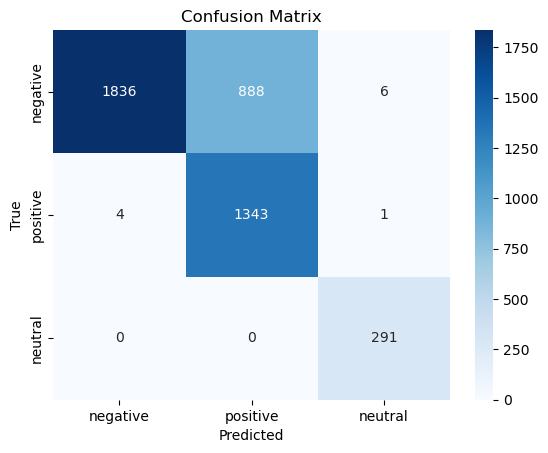

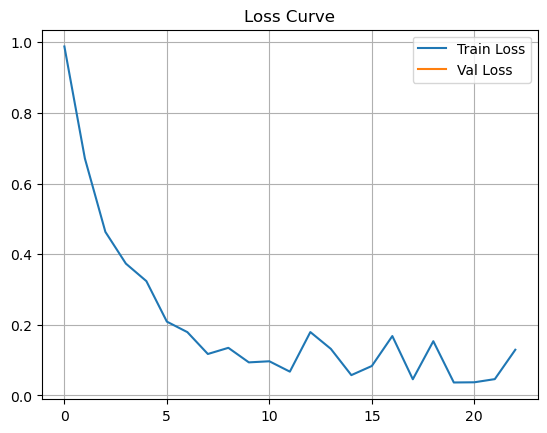

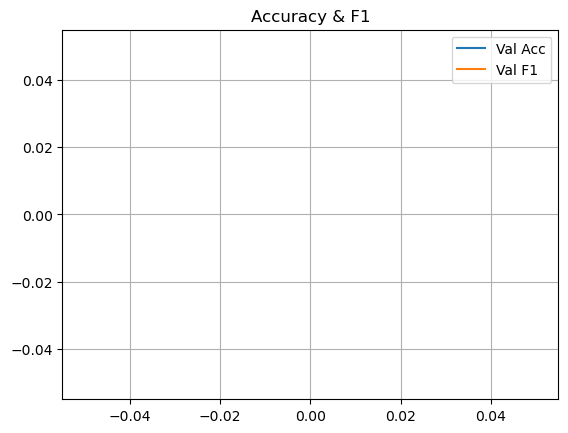

In [4]:
# ====================== Imports ======================
import os, re, torch, random, numpy as np
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 23
MAX_SEQ_LEN = 128
HIDDEN_DIM = 128
IMAGE_DIM = 128
TEXT_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        encoded = self.tokenizer(row["Captions"], padding="max_length", truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt")
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, encoded["input_ids"].squeeze(0), encoded["attention_mask"].squeeze(0), label

# ====================== CNN Encoder ======================
class CNNImageEncoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        from torchvision import models
        base_model = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512 * 2, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        avg_feat = self.avgpool(x).view(x.size(0), -1)
        max_feat = self.maxpool(x).view(x.size(0), -1)
        feat = torch.cat([avg_feat, max_feat], dim=1)
        return self.fc(feat)

# ====================== Text Encoder ======================
class TextEncoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("csebuetnlp/banglabert")
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.ReLU()
        )

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)
        return self.fc(x)

# ====================== Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, image_dim, text_dim, hidden_dim, num_classes):
        super().__init__()
        self.image_encoder = CNNImageEncoder(image_dim)
        self.text_encoder = TextEncoder(hidden_dim, text_dim)
        self.attn = nn.Sequential(
            nn.Linear(image_dim + text_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(image_dim + text_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.image_encoder(image)
        txt_feat = self.text_encoder(input_ids, attention_mask)
        combined = torch.cat((img_feat, txt_feat), dim=1)
        weight = self.attn(combined)
        fusion = weight * img_feat + (1 - weight) * txt_feat
        full_feat = torch.cat([img_feat, txt_feat], dim=1)
        return self.classifier(full_feat)

# ====================== Dataset & Sampler ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
tokenizer = BertTokenizer.from_pretrained("csebuetnlp/banglabert")
dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes")

# Balanced sampler
labels = df["Label_Sentiment"].map(LABEL_MAP).values
class_counts = np.bincount(labels)
weights = 1. / class_counts[labels]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

# ====================== Model, Loss, Optimizer ======================
model = VisionTextClassifier(IMAGE_DIM, TEXT_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
    def forward(self, input, target):
        ce_loss = nn.CrossEntropyLoss(weight=self.weight, reduction='none')(input, target)
        pt = torch.exp(-ce_loss)
        return (self.alpha * (1-pt)**self.gamma * ce_loss).mean()

criterion = FocalLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ====================== Training ======================
train_losses, val_losses, val_accs, val_f1s = [], [], [], []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for img, ids, mask, lbl in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        img, ids, mask, lbl = img.to(device), ids.to(device), mask.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(img, ids, mask)
        loss = criterion(out, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for img, ids, mask, lbl in DataLoader(dataset, batch_size=BATCH_SIZE):
            img, ids, mask = img.to(device), ids.to(device), mask.to(device)
            out = model(img, ids, mask)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(lbl.numpy())
            # val_loss += criterion(output, lbl).item()

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    print(f"\nEpoch {epoch+1}: Train Loss={total_loss:.4f}  Val Acc={acc:.4f}  F1={f1:.4f}")
    print(classification_report(targets, preds, target_names=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)]))
    scheduler.step()
    # val_losses.append(val_loss / len(val_loader))
    # val_accs.append(acc)
    # val_f1s.append(f1)
    # ====================== Plots ======================
os.makedirs("plots", exist_ok=True)
plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()


c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 1/23: 100%|██████████| 274/274 [01


Epoch 1: Train Loss=264.9633  Val Acc=0.2513  F1=0.1601
              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2730
    positive       0.38      0.62      0.47      1348
     neutral       0.12      0.90      0.21       291

    accuracy                           0.25      4369
   macro avg       0.17      0.51      0.23      4369
weighted avg       0.13      0.25      0.16      4369



Epoch 2/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 2/23: 100%|██████████| 274/274 [02:01<00:00,  2.25it/s]



Epoch 2: Train Loss=176.2451  Val Acc=0.3117  F1=0.2111
              precision    recall  f1-score   support

    negative       0.85      0.03      0.05      2730
    positive       0.40      0.74      0.52      1348
     neutral       0.16      0.98      0.28       291

    accuracy                           0.31      4369
   macro avg       0.47      0.58      0.28      4369
weighted avg       0.66      0.31      0.21      4369



Epoch 3/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 3/23: 100%|██████████| 274/274 [02:02<00:00,  2.24it/s]



Epoch 3: Train Loss=127.2297  Val Acc=0.3628  F1=0.2497
              precision    recall  f1-score   support

    negative       0.84      0.05      0.10      2730
    positive       0.38      0.86      0.53      1348
     neutral       0.25      1.00      0.40       291

    accuracy                           0.36      4369
   macro avg       0.49      0.64      0.34      4369
weighted avg       0.66      0.36      0.25      4369



Epoch 4/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 4/23: 100%|██████████| 274/274 [02:05<00:00,  2.19it/s]



Epoch 4: Train Loss=102.6566  Val Acc=0.3658  F1=0.2260
              precision    recall  f1-score   support

    negative       0.85      0.03      0.05      2730
    positive       0.36      0.92      0.52      1348
     neutral       0.34      0.98      0.51       291

    accuracy                           0.37      4369
   macro avg       0.52      0.64      0.36      4369
weighted avg       0.67      0.37      0.23      4369



Epoch 5/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 5/23: 100%|██████████| 274/274 [02:01<00:00,  2.26it/s]



Epoch 5: Train Loss=89.8111  Val Acc=0.3999  F1=0.2799
              precision    recall  f1-score   support

    negative       0.89      0.07      0.12      2730
    positive       0.37      0.95      0.53      1348
     neutral       0.43      0.98      0.60       291

    accuracy                           0.40      4369
   macro avg       0.56      0.67      0.42      4369
weighted avg       0.70      0.40      0.28      4369



Epoch 6/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 6/23: 100%|██████████| 274/274 [02:02<00:00,  2.24it/s]



Epoch 6: Train Loss=69.7249  Val Acc=0.3978  F1=0.2660
              precision    recall  f1-score   support

    negative       0.97      0.04      0.08      2730
    positive       0.35      0.99      0.51      1348
     neutral       0.73      0.99      0.84       291

    accuracy                           0.40      4369
   macro avg       0.68      0.67      0.48      4369
weighted avg       0.76      0.40      0.27      4369



Epoch 7/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 7/23: 100%|██████████| 274/274 [01:50<00:00,  2.49it/s]



Epoch 7: Train Loss=44.5512  Val Acc=0.4404  F1=0.3466
              precision    recall  f1-score   support

    negative       0.97      0.11      0.20      2730
    positive       0.36      0.99      0.53      1348
     neutral       0.80      1.00      0.89       291

    accuracy                           0.44      4369
   macro avg       0.71      0.70      0.54      4369
weighted avg       0.77      0.44      0.35      4369



Epoch 8/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 8/23: 100%|██████████| 274/274 [02:02<00:00,  2.24it/s]



Epoch 8: Train Loss=38.1925  Val Acc=0.5006  F1=0.4471
              precision    recall  f1-score   support

    negative       0.96      0.21      0.35      2730
    positive       0.39      0.97      0.56      1348
     neutral       0.76      1.00      0.86       291

    accuracy                           0.50      4369
   macro avg       0.70      0.73      0.59      4369
weighted avg       0.77      0.50      0.45      4369



Epoch 9/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 9/23: 100%|██████████| 274/274 [02:01<00:00,  2.25it/s]



Epoch 9: Train Loss=54.7776  Val Acc=0.4351  F1=0.3374
              precision    recall  f1-score   support

    negative       0.98      0.10      0.18      2730
    positive       0.36      0.99      0.52      1348
     neutral       0.86      1.00      0.93       291

    accuracy                           0.44      4369
   macro avg       0.73      0.70      0.54      4369
weighted avg       0.78      0.44      0.34      4369



Epoch 10/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 10/23: 100%|██████████| 274/274 [01:54<00:00,  2.40it/s]



Epoch 10: Train Loss=53.1514  Val Acc=0.4701  F1=0.3982
              precision    recall  f1-score   support

    negative       0.98      0.16      0.27      2730
    positive       0.37      0.99      0.54      1348
     neutral       0.90      0.99      0.94       291

    accuracy                           0.47      4369
   macro avg       0.75      0.71      0.58      4369
weighted avg       0.79      0.47      0.40      4369



Epoch 11/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 11/23: 100%|██████████| 274/274 [02:01<00:00,  2.25it/s]



Epoch 11: Train Loss=23.3071  Val Acc=0.5800  F1=0.5579
              precision    recall  f1-score   support

    negative       0.98      0.34      0.50      2730
    positive       0.43      0.99      0.60      1348
     neutral       0.85      1.00      0.92       291

    accuracy                           0.58      4369
   macro avg       0.75      0.77      0.67      4369
weighted avg       0.80      0.58      0.56      4369



Epoch 12/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 12/23: 100%|██████████| 274/274 [01:52<00:00,  2.43it/s]



Epoch 12: Train Loss=40.9540  Val Acc=0.5969  F1=0.5794
              precision    recall  f1-score   support

    negative       0.99      0.36      0.53      2730
    positive       0.44      0.99      0.61      1348
     neutral       0.86      1.00      0.93       291

    accuracy                           0.60      4369
   macro avg       0.76      0.78      0.69      4369
weighted avg       0.81      0.60      0.58      4369



Epoch 13/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 13/23: 100%|██████████| 274/274 [02:02<00:00,  2.24it/s]



Epoch 13: Train Loss=40.1573  Val Acc=0.4994  F1=0.4431
              precision    recall  f1-score   support

    negative       1.00      0.20      0.33      2730
    positive       0.38      1.00      0.55      1348
     neutral       0.92      1.00      0.96       291

    accuracy                           0.50      4369
   macro avg       0.77      0.73      0.62      4369
weighted avg       0.80      0.50      0.44      4369



Epoch 14/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 14/23: 100%|██████████| 274/274 [02:01<00:00,  2.26it/s]



Epoch 14: Train Loss=16.2223  Val Acc=0.5555  F1=0.5253
              precision    recall  f1-score   support

    negative       1.00      0.29      0.45      2730
    positive       0.41      1.00      0.58      1348
     neutral       0.94      1.00      0.97       291

    accuracy                           0.56      4369
   macro avg       0.78      0.76      0.67      4369
weighted avg       0.81      0.56      0.53      4369



Epoch 15/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 15/23: 100%|██████████| 274/274 [02:01<00:00,  2.25it/s]



Epoch 15: Train Loss=16.0169  Val Acc=0.6567  F1=0.6519
              precision    recall  f1-score   support

    negative       1.00      0.45      0.62      2730
    positive       0.48      0.99      0.65      1348
     neutral       0.92      1.00      0.96       291

    accuracy                           0.66      4369
   macro avg       0.80      0.82      0.74      4369
weighted avg       0.83      0.66      0.65      4369



Epoch 16/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 16/23: 100%|██████████| 274/274 [02:03<00:00,  2.23it/s]



Epoch 16: Train Loss=42.2402  Val Acc=0.6402  F1=0.6338
              precision    recall  f1-score   support

    negative       0.99      0.43      0.60      2730
    positive       0.46      0.99      0.63      1348
     neutral       0.97      1.00      0.99       291

    accuracy                           0.64      4369
   macro avg       0.81      0.81      0.74      4369
weighted avg       0.83      0.64      0.63      4369



Epoch 17/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 17/23: 100%|██████████| 274/274 [02:01<00:00,  2.25it/s]



Epoch 17: Train Loss=43.4550  Val Acc=0.6317  F1=0.6232
              precision    recall  f1-score   support

    negative       1.00      0.41      0.58      2730
    positive       0.46      1.00      0.63      1348
     neutral       0.97      1.00      0.98       291

    accuracy                           0.63      4369
   macro avg       0.81      0.80      0.73      4369
weighted avg       0.83      0.63      0.62      4369



Epoch 18/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 18/23: 100%|██████████| 274/274 [02:02<00:00,  2.23it/s]



Epoch 18: Train Loss=10.8656  Val Acc=0.7542  F1=0.7586
              precision    recall  f1-score   support

    negative       1.00      0.61      0.76      2730
    positive       0.56      0.99      0.72      1348
     neutral       0.95      1.00      0.98       291

    accuracy                           0.75      4369
   macro avg       0.84      0.87      0.82      4369
weighted avg       0.86      0.75      0.76      4369



Epoch 19/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 19/23: 100%|██████████| 274/274 [02:03<00:00,  2.22it/s]



Epoch 19: Train Loss=10.1116  Val Acc=0.7741  F1=0.7788
              precision    recall  f1-score   support

    negative       0.99      0.64      0.78      2730
    positive       0.58      0.99      0.73      1348
     neutral       0.94      1.00      0.97       291

    accuracy                           0.77      4369
   macro avg       0.84      0.88      0.83      4369
weighted avg       0.86      0.77      0.78      4369



Epoch 20/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 20/23: 100%|██████████| 274/274 [02:02<00:00,  2.23it/s]



Epoch 20: Train Loss=40.8677  Val Acc=0.7530  F1=0.7575
              precision    recall  f1-score   support

    negative       1.00      0.61      0.75      2730
    positive       0.56      1.00      0.72      1348
     neutral       0.96      1.00      0.98       291

    accuracy                           0.75      4369
   macro avg       0.84      0.87      0.82      4369
weighted avg       0.86      0.75      0.76      4369



Epoch 21/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 21/23: 100%|██████████| 274/274 [02:02<00:00,  2.23it/s]



Epoch 21: Train Loss=10.4620  Val Acc=0.8162  F1=0.8209
              precision    recall  f1-score   support

    negative       0.99      0.71      0.83      2730
    positive       0.63      0.99      0.77      1348
     neutral       0.95      1.00      0.98       291

    accuracy                           0.82      4369
   macro avg       0.86      0.90      0.86      4369
weighted avg       0.88      0.82      0.82      4369



Epoch 22/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 22/23: 100%|██████████| 274/274 [02:04<00:00,  2.20it/s]



Epoch 22: Train Loss=9.5289  Val Acc=0.8306  F1=0.8350
              precision    recall  f1-score   support

    negative       1.00      0.73      0.84      2730
    positive       0.65      1.00      0.79      1348
     neutral       0.95      1.00      0.97       291

    accuracy                           0.83      4369
   macro avg       0.87      0.91      0.87      4369
weighted avg       0.89      0.83      0.83      4369



Epoch 23/23:   0%|          | 0/274 [00:00<?, ?it/s]c:\Users\USERAS\anaconda3\envs\resPy\Lib\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
Epoch 23/23: 100%|██████████| 274/274 [02:01<00:00,  2.26it/s]



Epoch 23: Train Loss=7.6501  Val Acc=0.8581  F1=0.8616
              precision    recall  f1-score   support

    negative       1.00      0.78      0.87      2730
    positive       0.69      0.99      0.82      1348
     neutral       0.93      1.00      0.97       291

    accuracy                           0.86      4369
   macro avg       0.87      0.92      0.88      4369
weighted avg       0.90      0.86      0.86      4369



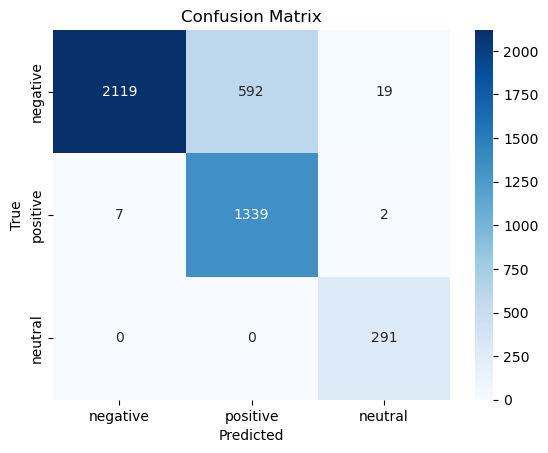

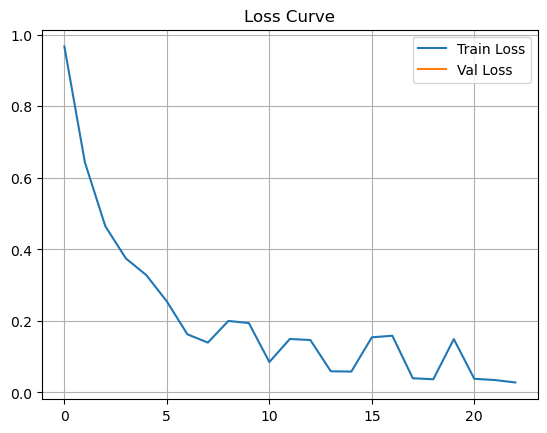

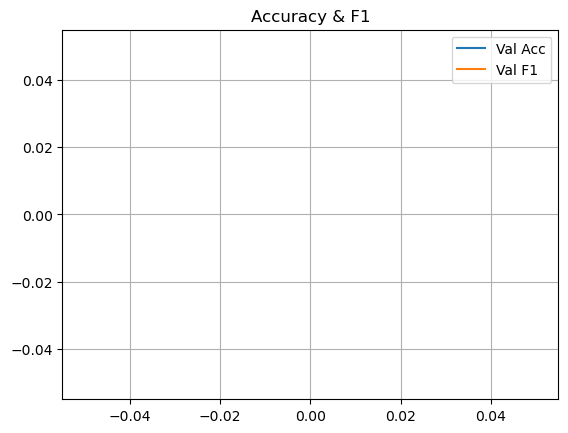

In [3]:
# ====================== Imports ======================
import os, re, torch, random, numpy as np
import torch.nn as nn
import pandas as pd
from PIL import Image
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import torchvision.transforms as transforms
from transformers import BertTokenizer, BertModel

# ====================== Constants ======================
LABEL_MAP = {'positive': 1, 'neutral': 2, 'negative': 0}
INV_LABEL_MAP = {v: k for k, v in LABEL_MAP.items()}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 16
EPOCHS = 23
MAX_SEQ_LEN = 128
HIDDEN_DIM = 128
IMAGE_DIM = 128
TEXT_DIM = 128
NUM_CLASSES = len(LABEL_MAP)

# ====================== Seed Fix ======================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

# ====================== Dataset ======================
class VisionTextDataset(Dataset):
    def __init__(self, df, tokenizer, image_folder, transform=None):
        self.df = df.reset_index(drop=True)
        self.tokenizer = tokenizer
        self.image_folder = image_folder
        self.transform = transform or transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.image_folder, row["image_name"])
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        encoded = self.tokenizer(row["Captions"], padding="max_length", truncation=True, max_length=MAX_SEQ_LEN, return_tensors="pt")
        label = LABEL_MAP[row["Label_Sentiment"].strip().lower()]
        return image, encoded["input_ids"].squeeze(0), encoded["attention_mask"].squeeze(0), label

# ====================== CNN Encoder ======================
class CNNImageEncoder(nn.Module):
    def __init__(self, output_dim):
        super().__init__()
        from torchvision import models
        base_model = models.resnet18(pretrained=True)
        self.features = nn.Sequential(*list(base_model.children())[:-2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.maxpool = nn.AdaptiveMaxPool2d((1, 1))
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(512 * 2, output_dim),
            nn.ReLU()
        )

    def forward(self, x):
        x = self.features(x)
        avg_feat = self.avgpool(x).view(x.size(0), -1)
        max_feat = self.maxpool(x).view(x.size(0), -1)
        feat = torch.cat([avg_feat, max_feat], dim=1)
        return self.fc(feat)

# ====================== Text Encoder ======================
class TextEncoder(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_dim, batch_first=True, bidirectional=True)
        self.gru = nn.GRU(hidden_dim * 2, hidden_dim, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(hidden_dim * 2, output_dim),
            nn.ReLU()
        )

    def forward(self, input_ids, attention_mask):
        with torch.no_grad():
            x = self.bert(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        x, _ = self.lstm(x)
        x, _ = self.gru(x)
        x = torch.mean(x, dim=1)
        return self.fc(x)

# ====================== Classifier ======================
class VisionTextClassifier(nn.Module):
    def __init__(self, image_dim, text_dim, hidden_dim, num_classes):
        super().__init__()
        self.image_encoder = CNNImageEncoder(image_dim)
        self.text_encoder = TextEncoder(hidden_dim, text_dim)
        self.attn = nn.Sequential(
            nn.Linear(image_dim + text_dim, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )
        self.classifier = nn.Sequential(
            nn.Linear(image_dim + text_dim, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, image, input_ids, attention_mask):
        img_feat = self.image_encoder(image)
        txt_feat = self.text_encoder(input_ids, attention_mask)
        combined = torch.cat((img_feat, txt_feat), dim=1)
        weight = self.attn(combined)
        fusion = weight * img_feat + (1 - weight) * txt_feat
        full_feat = torch.cat([img_feat, txt_feat], dim=1)
        return self.classifier(full_feat)

# ====================== Dataset & Sampler ======================
df = pd.read_excel("Dataset/multi-sent.xlsx")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = VisionTextDataset(df, tokenizer, "Dataset/Memes")

# Balanced sampler
labels = df["Label_Sentiment"].map(LABEL_MAP).values
class_counts = np.bincount(labels)
weights = 1. / class_counts[labels]
sampler = WeightedRandomSampler(weights, len(weights))

train_loader = DataLoader(dataset, batch_size=BATCH_SIZE, sampler=sampler)

# ====================== Model, Loss, Optimizer ======================
model = VisionTextClassifier(IMAGE_DIM, TEXT_DIM, HIDDEN_DIM, NUM_CLASSES).to(device)

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight
    def forward(self, input, target):
        ce_loss = nn.CrossEntropyLoss(weight=self.weight, reduction='none')(input, target)
        pt = torch.exp(-ce_loss)
        return (self.alpha * (1-pt)**self.gamma * ce_loss).mean()

criterion = FocalLoss(weight=class_weights)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# ====================== Training ======================
train_losses, val_losses, val_accs, val_f1s = [], [], [], []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for img, ids, mask, lbl in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        img, ids, mask, lbl = img.to(device), ids.to(device), mask.to(device), lbl.to(device)
        optimizer.zero_grad()
        out = model(img, ids, mask)
        loss = criterion(out, lbl)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 2.0)
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))

    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for img, ids, mask, lbl in DataLoader(dataset, batch_size=BATCH_SIZE):
            img, ids, mask = img.to(device), ids.to(device), mask.to(device)
            out = model(img, ids, mask)
            preds.extend(out.argmax(1).cpu().numpy())
            targets.extend(lbl.numpy())
            # val_loss += criterion(output, lbl).item()

    acc = accuracy_score(targets, preds)
    f1 = f1_score(targets, preds, average='weighted')
    print(f"\nEpoch {epoch+1}: Train Loss={total_loss:.4f}  Val Acc={acc:.4f}  F1={f1:.4f}")
    print(classification_report(targets, preds, target_names=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)]))
    scheduler.step()
    # val_losses.append(val_loss / len(val_loader))
    # val_accs.append(acc)
    # val_f1s.append(f1)
    # ====================== Plots ======================
os.makedirs("plots", exist_ok=True)
plt.figure()
sns.heatmap(confusion_matrix(targets, preds), annot=True, fmt="d", cmap="Blues",
            xticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)],
            yticklabels=[INV_LABEL_MAP[i] for i in range(NUM_CLASSES)])
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix")
plt.savefig("plots/confusion_matrix.png"); plt.show()

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve"); plt.legend(); plt.grid(); plt.savefig("plots/loss.png"); plt.show()

plt.plot(val_accs, label="Val Acc")
plt.plot(val_f1s, label="Val F1")
plt.title("Accuracy & F1"); plt.legend(); plt.grid(); plt.savefig("plots/acc_f1.png"); plt.show()
